In [28]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import os



In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
n_samples = 10000
fraud_ratio = 0.03
n_frauds = int(n_samples * fraud_ratio)


transaction_amounts = np.round(np.random.lognormal(mean=10, sigma=1, size=n_samples), 2)

transaction_amounts = np.clip(transaction_amounts, 1000, 100000).astype(int)


transaction_times = np.random.randint(0, 24, size=n_samples)


indian_states = ['Gujarat', 'Maharashtra', 'Delhi', 'Karnataka', 'Tamil Nadu', 'Uttar Pradesh', 'Rajasthan', 'West Bengal']
user_locations = np.random.choice(indian_states, size=n_samples)
merchant_locations = np.random.choice(indian_states, size=n_samples)


card_present = np.random.choice([0, 1], size=n_samples, p=[0.4, 0.6])


device_types = np.random.choice(['mobile', 'web', 'ATM'], size=n_samples, p=[0.5, 0.4, 0.1])


user_ids = [f'user_{np.random.randint(1, 501)}' for _ in range(n_samples)]


is_fraud = np.array([1]*n_frauds + [0]*(n_samples - n_frauds))
np.random.shuffle(is_fraud)


data = pd.DataFrame({
    'transaction_amount': transaction_amounts,
    'transaction_time': transaction_times,
    'user_location': user_locations,
    'merchant_location': merchant_locations,
    'card_present': card_present,
    'device_type': device_types,
    'user_id': user_ids,
    'is_fraud': is_fraud
})




In [4]:
data.head(20)

,transaction_amount,transaction_time,user_location,merchant_location,card_present,device_type,user_id,is_fraud
0,36196,9,Tamil Nadu,Maharashtra,0,web,user_315,0
1,19182,23,Uttar Pradesh,Karnataka,1,mobile,user_134,0
2,42095,16,Maharashtra,West Bengal,1,web,user_43,0
3,100000,20,Rajasthan,Delhi,1,web,user_94,0
4,17428,1,Rajasthan,Maharashtra,1,mobile,user_180,0
5,17428,5,Gujarat,Tamil Nadu,1,mobile,user_359,0
6,100000,4,Tamil Nadu,Tamil Nadu,1,mobile,user_256,0
7,47450,3,Rajasthan,Karnataka,0,mobile,user_446,0
8,13773,1,Gujarat,Delhi,0,mobile,user_242,0
9,37894,11,Gujarat,Karnataka,1,ATM,user_224,0


In [5]:
df = data.copy()

df['is_same_state'] = (df['user_location'] == df['merchant_location']).astype(int)

location_fraud_rate = df.groupby('user_location')['is_fraud'].mean().to_dict()
df['location_risk_score'] = df['user_location'].map(location_fraud_rate)

df['user_avg_amount'] = df.groupby('user_id')['transaction_amount'].transform('mean')

df['user_txn_count'] = df['user_id'].map(df['user_id'].value_counts())

df['device_freq_per_user'] = df.groupby(['user_id', 'device_type'])['device_type'].transform('count')

df['online_txn_ratio'] = df.groupby('user_id')['card_present'].transform(lambda x: 1 - x.mean())


In [6]:
categorical_cols = ['user_location', 'merchant_location', 'device_type', 'user_id']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
df[['transaction_amount', 'transaction_time', 'user_avg_amount']] = scaler.fit_transform(
    df[['transaction_amount', 'transaction_time', 'user_avg_amount']]
)


In [7]:
df.head(10)

,transaction_amount,transaction_time,user_location,merchant_location,card_present,device_type,user_id,is_fraud,is_same_state,location_risk_score,user_avg_amount,user_txn_count,device_freq_per_user,online_txn_ratio
0,0.159888,-0.362610,5,3,0,2,240,0,0,0.022043,-0.793912,36,16,0.444444
1,-0.454574,1.672403,6,2,1,1,39,0,0,0.027638,-0.807356,12,8,0.333333
2,0.372930,0.654896,3,7,1,2,367,0,0,0.029511,-0.603485,20,7,0.450000
3,2.464173,1.236329,4,0,1,2,494,0,0,0.022099,-0.937104,26,8,0.384615
4,-0.517920,-1.525475,4,3,1,1,90,0,0,0.022099,-1.052616,26,17,0.538462
5,-0.517920,-0.944043,1,5,1,1,288,0,0,0.043089,-1.350307,23,13,0.434783
6,2.464173,-1.089401,5,5,1,1,174,0,1,0.022043,1.192318,20,10,0.400000
7,0.566327,-1.234759,4,2,0,1,385,0,0,0.022099,-0.668929,24,11,0.416667
8,-0.649921,-1.525475,1,0,0,1,159,0,0,0.043089,-0.153765,16,10,0.375000
9,0.221211,-0.071894,1,2,1,0,139,0,0,0.043089,-0.734566,23,2,0.304348


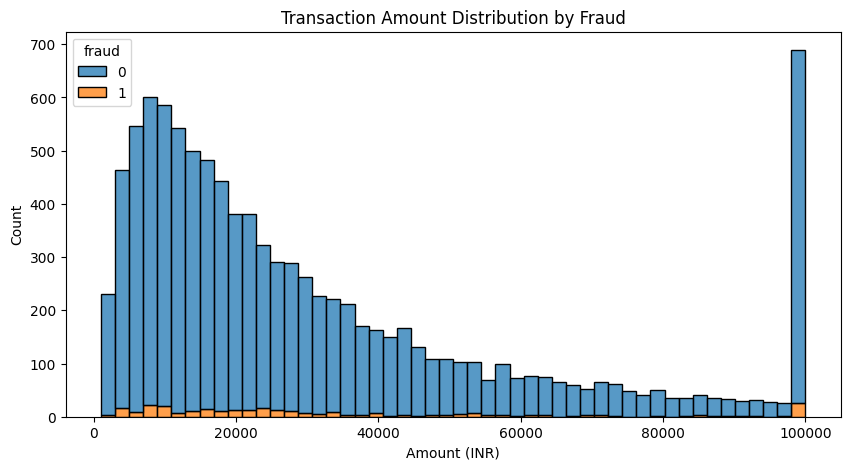

In [8]:
data['fraud'] = data['is_fraud']

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='transaction_amount', bins=50, hue='fraud', multiple='stack')
plt.title("Transaction Amount Distribution by Fraud")
plt.xlabel("Amount (INR)")
plt.ylabel("Count")
plt.show()

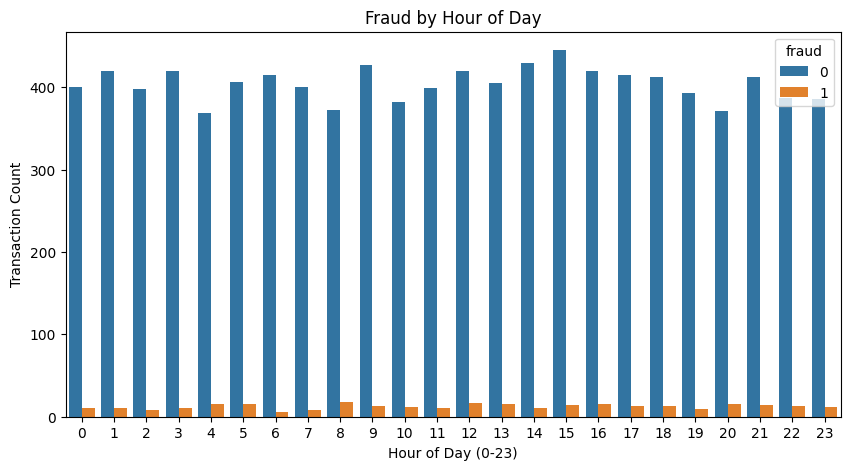

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='transaction_time', hue='fraud')
plt.title("Fraud by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Transaction Count")
plt.show()

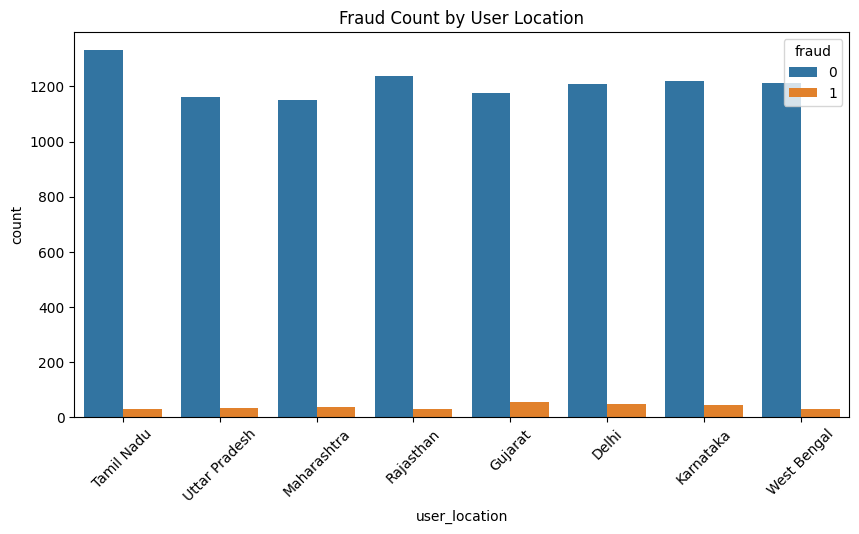

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='user_location', hue='fraud')
plt.title("Fraud Count by User Location")
plt.xticks(rotation=45)
plt.show()

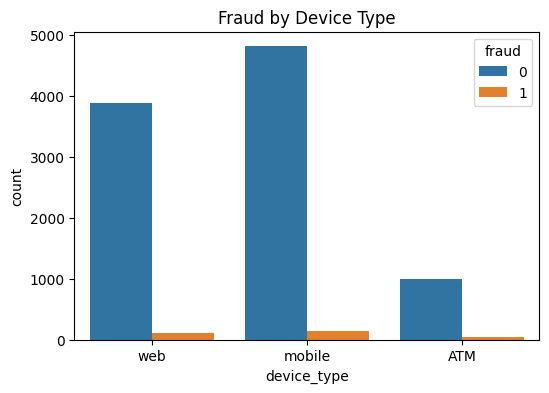

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='device_type', hue='fraud')
plt.title("Fraud by Device Type")
plt.show()

In [12]:
data['is_fraud'].value_counts(normalize=True)


,proportion
is_fraud,
0,0.97
1,0.03


In [13]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [15]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

In [17]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[1933    7]
 [  60    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1940
           1       0.00      0.00      0.00        60

    accuracy                           0.97      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.94      0.97      0.95      2000


ROC AUC Score: 0.5447036082474227


In [18]:
xgb_model = XGBClassifier(n_estimators=100, scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:14:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob > 0.2).astype(int)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[1845   95]
 [  56    4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1940
           1       0.04      0.07      0.05        60

    accuracy                           0.92      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.94      0.92      0.93      2000


ROC AUC Score: 0.5006185567010308


In [20]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    subsample=0.9,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

xgb_model.fit(X_train_bal, y_train_bal)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:14:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb > 0.2).astype(int)

print("🔍 XGBoost Evaluation")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))

🔍 XGBoost Evaluation
[[1123  817]
 [  33   27]]
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      1940
           1       0.03      0.45      0.06        60

    accuracy                           0.57      2000
   macro avg       0.50      0.51      0.39      2000
weighted avg       0.94      0.57      0.71      2000

ROC AUC: 0.5375429553264605


In [25]:
iso = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso.fit(X_train[y_train == 0])



IsolationForest(contamination=0.03, random_state=42)

In [26]:
iso_preds = iso.predict(X_test)
y_pred_iso = np.where(iso_preds == -1, 1, 0)

print("🔍 Isolation Forest Evaluation")
print(confusion_matrix(y_test, y_pred_iso))
print(classification_report(y_test, y_pred_iso))
print("ROC AUC:", roc_auc_score(y_test, y_pred_iso))

🔍 Isolation Forest Evaluation
[[1892   48]
 [  55    5]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1940
           1       0.09      0.08      0.09        60

    accuracy                           0.95      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.95      0.95      0.95      2000

ROC AUC: 0.529295532646048


In [27]:
final_preds = ((y_pred_xgb == 1) | (y_pred_iso == 1)).astype(int)

print("🔍 Combined Model (XGB + ISO) Evaluation")
print(confusion_matrix(y_test, final_preds))
print(classification_report(y_test, final_preds))
print("ROC AUC (XGB only):", roc_auc_score(y_test, y_prob_xgb))


🔍 Combined Model (XGB + ISO) Evaluation
[[1080  860]
 [  30   30]]
              precision    recall  f1-score   support

           0       0.97      0.56      0.71      1940
           1       0.03      0.50      0.06        60

    accuracy                           0.56      2000
   macro avg       0.50      0.53      0.39      2000
weighted avg       0.94      0.56      0.69      2000

ROC AUC (XGB only): 0.5375429553264605


In [29]:
os.makedirs("model", exist_ok=True)

joblib.dump(xgb_model, "model/final_xgb_model.pkl")

joblib.dump(iso, "model/final_iso_model.pkl")

joblib.dump(scaler, "model/scaler.pkl")

joblib.dump(label_encoders, "model/label_encoders.pkl")

print("All models and tools saved successfully.")


✅ All models and tools saved successfully.
